In [1]:
%matplotlib notebook
import matplotlib as mpl
import itertools
import PyVal
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import ipyparallel as ipp
import seaborn as sns
import gzip
from tqdm import tqdm_notebook
from functools import reduce

In [2]:
idx = pd.IndexSlice
rc = ipp.Client()#('/home/julian/.ipython/profile_ssh/security/ipcontroller-client.json')
dview = rc.load_balanced_view()
print(rc.ids)
sns.set_style("whitegrid")

def send_file(dview, local_path, remote_path):
    """Send a single file"""
    print("sending file", local_path, remote_path)
    import io, os
    
    def _recv(remote_path, bdata, mtime):
        import io, os
        if os.path.exists(remote_path):
            os.unlink(remote_path)
        with io.open(remote_path, 'wb') as f:
            f.write(data)
        os.utime(remote_path, (mtime, mtime))
    
    st = os.stat(local_path)
    with io.open(local_path, 'rb') as f:
        data = f.read()
    
    yield dview.apply_async(_recv, remote_path, data, st.st_mtime)
    
#TODO: use chrpath PyVal.so -r . to make libtrng visible
#for el in send_file(dview, '../build/PyVal.cpython-36m-x86_64-linux-gnu.so','./PyVal.so'):
    
    print(el.get())
for el in send_file(dview, '../external/lib/libtrng4.so.19', './libtrng4.so.19'):
    pass
for el in send_file(dview, '../external/lib/libtrng4.so', './libtrng4.so'):
    pass

with rc[:].sync_imports():
    import PyVal
    import numpy as np


/home/julian/.local/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@julian-ThinkPad-W530')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


[0, 1, 2, 3, 4, 5]
sending file ../external/lib/libtrng4.so.19 ./libtrng4.so.19
None
sending file ../external/lib/libtrng4.so ./libtrng4.so
None
importing PyVal on engine(s)
importing numpy on engine(s)


In [12]:
#@ipp.require('PyVal', 'numpy')
indices = ['S0','T', 'r', 'N', 'col sum', 'default scale', 'conn', 'sigma']
col_names = ['M', 'Assets', 'RS', 'Delta', 'Vega', 'Theta', 'Rho', 'Pi', 'Solvent']
tmp_cols = ['N_MC', 'N_nets', 'Number Of Samples', 'p']

def reduce_to_scalars(df, N, conn_scale):
    print("starting reduce to sclars")
    #cols = df.columns.values
    #cols = np.delete(cols, np.where((cols == 'RS') | (cols == 'Delta') | (cols == 'Delta var') | (cols == 'Vega') |\
    #                            (cols == 'Vega') | (cols == 'Vega var') | (cols == 'Rho') | (cols == 'Rho var') |\
    #                            (cols == 'Theta') | (cols == 'Theta var') | (cols == 'Pi') | (cols == 'Pi var') |\
    #                            (cols == 'M') | (cols == 'M var') | (cols == 'N_MC') | (cols == 'N_nets') |\
    #                            (cols == 'col sum') ))
    cols =  np.array(['N', 'r', 'T', 'conn', 'default scale', 'col sum', 'S0', 'sigma',\
                      'Solvent', 'Solvent var', 'Assets', 'Assets var', 'R', 'S', \
                      'equity Delta', 'equity Delta var', 'debt Delta', 'debt Delta var',\
                      'equity Vega', 'equity Vega var', 'debt Vega', 'debt Vega var',\
                      'equity Rho', 'equity Rho var', 'debt Rho', 'debt Rho var',\
                      'equity Theta', 'equity Theta var', 'debt Theta', 'debt Theta var',\
                      'Pi', 'Pi var',\
                      'equity col sum', 'debt col sum', 'equity row sum', 'debt row sum'])
    df2 = pd.DataFrame(columns = cols, dtype=np.float64)
    df2['Number Of Samples'] = df['Number Of Samples'].transform(lambda x: x[1])
    df2['S'] = df['RS'].transform(lambda x: np.average(x[:N]))
    df2['R'] = df['RS'].transform(lambda x: np.average(x[N:]))
    df2['equity Delta'] = df['Delta'].transform(lambda x: np.sum(x[:N,:])/N)
    df2['equity Delta var'] = df['Delta var'].transform(lambda x: np.sum(x[:N,:])/N)
    print("before greeks")
    df2['debt Delta'] = df['Delta'].transform(lambda x: np.sum(x[N:,:])/N)
    df2['debt Delta var'] = df['Delta var'].transform(lambda x: np.sum(x[N:,:])/N)
    for el in ['Vega', 'Rho', 'Theta']:
        df2['equity ' + el] = df[el].transform(lambda x: np.sum(x[:,:N])/N)
        df2['equity ' +el+ ' var'] = df[el+' var'].transform(lambda x: np.sum(x[:,:N])/N)
        df2['debt ' + el] = df[el].transform(lambda x: np.sum(x[:,N:])/N)
        df2['debt ' +el+' var'] = df[el+' var'].transform(lambda x: np.sum(x[:,N:])/N)
    df2['equity col sum'] = df['M'].transform(lambda x: np.average(np.sum(x[:,:N], axis=0)))
    df2['debt col sum']   = df['M'].transform(lambda x: np.average(np.sum(x[:,N:], axis=0)))
    df2['equity row sum'] = df['M'].transform(lambda x: np.average(np.sum(x[:,:N], axis=1)))
    df2['debt row sum']   = df['M'].transform(lambda x: np.average(np.sum(x[:,N:], axis=1)))
    print("before assets")
    df2['Assets'] = df['Assets'].transform(lambda x: np.average(x))
    df2['Assets var'] = df['Assets var'].transform(lambda x: np.average(x))
    df2['Solvent'] = df['Solvent'].transform(lambda x: np.average(x))
    df2['Solvent var'] = df['Solvent var'].transform(lambda x: np.average(x))
    df2['Pi'] = df['Pi'].transform(lambda x: np.average(x))
    df2['Pi var'] = df['Pi var'].transform(lambda x: np.average(x))
    df2['N'] = df['N']
    df2['r'] = df['r']
    df2['T'] = df['T']
    df2['conn'] = df['conn'].transform(lambda x: x/conn_scale)
    df2['default scale'] = df['default scale']
    df2['col sum'] = df['col sum']
    df2['S0'] = df['S0']
    df2['sigma'] = df['sigma']
    #df2['p'] = df['p']
    
    return df2

def reduce_to_scalars_old(df, conn_scale):
    for ix in df.index:
        for ind in df.loc[ix].index:
            N = int(df.loc[ix,'N'])
            if ind == 'conn':
                df.loc[ix, ind] = df.loc[ix, ind]/conn_scale
            elif ind == 'Number Of Samples':
                df.loc[ix, ind] = df.loc[ix, ind][1]
            elif ind == 'RS':
                df.loc[ix, 'S'] = np.average(df.loc[ix, ind][:N])
                df.loc[ix, 'R'] = np.average(df.loc[ix, ind][N:])
                #df.loc[ix, 'R'] = df.loc[ix, ind]
            elif ind == 'Delta' or ind == 'Delta var' or ind == 'Vega' or ind == 'Vega var':
                df.loc[ix, ind] = np.sum(df.loc[ix, ind])/N
            elif ind == 'Rho'or ind == 'Theta' or ind == 'Pi' or ind == 'Rho var' or ind == 'Theta var' or ind == 'Pi var':
                df.loc[ix,"equity " + ind] = np.average(df.loc[ix, ind][:N])
                df.loc[ix,"debt " + ind] = np.average(df.loc[ix, ind][N:])
            elif ind == 'M' or ind == 'M var':
                df.loc[ix, 'avg col sum'] = np.average(np.sum(df.loc[ix, ind][:,N:], axis=0))
                df.loc[ix, 'avg row sum'] = np.average(np.sum(df.loc[ix, ind], axis=1))
                df.loc[ix, ind] = np.sum(df.loc[ix, ind])/N
            else:
                df.loc[ix, ind] = np.average(df.loc[ix, ind])
    df.drop(columns='RS', inplace=True)
    df.drop(columns='Delta', inplace=True)
    df.drop(columns='Delta var', inplace=True)
    df.drop(columns='Vega', inplace=True)
    df.drop(columns='Vega var', inplace=True)
    df.drop(columns='Rho', inplace=True)
    df.drop(columns='Rho var', inplace=True)
    df.drop(columns='Theta', inplace=True)
    df.drop(columns='Theta var', inplace=True)
    df.drop(columns='Pi', inplace=True)
    df.drop(columns='Pi var', inplace=True)
    df.drop(columns='M', inplace=True)
    df.drop(columns='M var', inplace=True)
    

def run_sim(N, row_val, col_val, p, T, r, S0, sigma, default_scale):
    import numpy as np
    mul = max(1,col_val+S0)
    N_MC = int(15000*(1+sigma))#int(400*mul)    # 600
    N_nets = 1#int(800*mul)  # 1100
    nw = PyVal.BS_Network()
    print("Runing N=" +str(N)+", col sum="+str(col_val)+", p="+str(p))
    nw.run(N, p, row_val, col_val, 2, T, r, S0, sigma, N_MC,  N_nets, default_scale)
    k_list = nw.k_vals()[0]
    res = []
    for k in k_list:
        res.append({'N': N, 'Number Of Samples': nw.get_N_samples(k)[0], 'default scale': default_scale,\
               'conn': k, 'col sum': col_val, 'T':T, 'r': r , 'sigma': sigma, 'p': p, 'S0': S0, \
               'M': nw.get_M(k), 'M var': nw.get_M_var(k),\
               'Assets': np.array(nw.get_assets(k))[0], 'Assets var': np.array(nw.get_assets_var(k))[0],\
               'RS': np.array(nw.get_rs(k))[0],  'RS var': np.array(nw.get_rs_var(k))[0],\
               'Delta': nw.get_delta_jacobians(k),  'Delta var': nw.get_delta_jacobians_var(k),\
               'Vega': np.array(nw.get_vega(k)),  'Vega var': np.array(nw.get_vega_var(k)),\
               'Theta': np.array(nw.get_theta(k)),  'Theta var': np.array(nw.get_theta_var(k)),\
               'Rho': np.array(nw.get_rho(k)),  'Rho var': np.array(nw.get_rho_var(k)),\
               'Solvent': np.array(nw.get_solvent(k)), 'Solvent var': np.array(nw.get_solvent_var(k)),\
               'Pi': np.array(nw.get_pi(k)),  'Pi var': np.array(nw.get_pi_var(k))\
                   })
    return res

def combine_2_results(dict1, dict2):
    import copy
    res = copy.deepcopy(dict1)
    for k in tmp_cols:
        if k in res:
            res.pop(k)
    index_ok = True
    for ind in indices:
        if dict1[ind] != dict2[ind]:
            index_ok = False
    if index_ok:
        res['Number Of Samples'] = dict1['Number Of Samples'] + dict2['Number Of Samples']
        n1 = dict1['Number Of Samples'][1]
        n2 = dict2['Number Of Samples'][1]
        n_tot = n1 + n2
        for el in col_names:
            elv = el + ' var'
            res[el] = (n1*dict1[el] + n2*dict2[el])/n_tot
            res[elv] = (n1*(dict1[elv] + dict1[el]*dict1[el]) + n2*(dict2[elv] + dict2[el]*dict2[el]))/n_tot - res[el]*res[el]
        return [res]
    else:
        return [dict1, dict2]

    
def results_to_df(results):
    import copy
    candidates = {}
    df_list = []
    for r_list in results:
        for res in r_list:
            key = tuple([res[ind] for ind in indices])
            if key in candidates:
                candidates[key].append(res)
            else:
                candidates[key] = [res]
    for key, value in candidates.items():
        res_in = copy.deepcopy(value)
        while len(res_in) > 1:
            el1 = res_in.pop()
            el2 = res_in.pop()
            res_in = res_in + combine_2_results(el1, el2)
        candidates[key] = res_in[0]
        df_list.append(res_in[0])
    #res.set_index(indices, inplace=True)
    return pd.DataFrame(df_list)
        
            
    
def flatten_input(cell):
    if type(cell) is list:
        return cell[0]
    else:
        return cell

def pList(N, pts):
    import numpy as np
    #    return np.union1d(np.union1d(np.linspace(0.0, 10.0/N, pts), np.linspace(0.6/N,1.4/N,pts)), np.linspace((np.log(N)-np.log(N)/7.)/N,(np.log(N)+np.log(N)/7.)/N,pts))
    res = np.union1d(np.linspace(0.0, 2.0/N, 2*pts), np.union1d(np.linspace(0.0, 8.0/N, pts), np.linspace((np.log(N)-np.log(N)/7.)/N, (np.log(N)+np.log(N)/7.)/N, pts)))
    res = res[res <= 5.0/N]
    return res

def pFixedList(N, pts):
    import numpy as np
    return np.linspace(0.0, (pts-1)/N, pts)

# Parameters
## Black Scholes
    - T = 1
    - r = 0
    
## Network Parameters
    - N = [15, 25, 50, 75, 100, 150, 200, 300]
    - <k> = n*p = [0 .. 1.8]
    - M => ER(N,p)

In [4]:
dview.block=False
Nlist = [2]
NPoints = 12
batch = 1
#default_scales_full = np.linspace(0.7,1.1,5)
default_scales = [1.0]# default_scales_full#[:5]
row_vals_all = np.linspace(0.1,0.7, 30)   #[0.1, 0.2, 0.4, 0.7]
row_vals = np.linspace(0.0,0.9,30)#np.array([0.0, 0.2, 0.4, 0.6, 0.8])#row_vals_all[batch::5]
S0_vals = np.linspace(0.11, 1.49, 30)
sigma_vals = np.linspace(0.1,0.6,10)
r_vals = np.linspace(0.0,0.5,10)#[0.0]#[0.0, 0.05, 0.1]
T_vals = np.linspace(0.1,5.0,10)#[1.0]
param_grid = [(N, row_sum, row_sum, 0.5, T, r, S0, sigma, default_scale) for N in Nlist[::-1] for row_sum in row_vals[::-1] 
              for default_scale in default_scales for r in r_vals for T in T_vals for S0 in S0_vals for sigma in sigma_vals]
len(param_grid)

900000

In [5]:
async_res = []
ids = []
for el in param_grid:
    with dview.temp_flags(retries=2):
        b_re = dview.apply_async(run_sim, *el)
        async_res.append(b_re)
        ids.extend(b_re.msg_ids)
filename = "param_grid_ER_2_LARGE_batch2"

In [7]:
done = 0
waiting = 0
for el in async_res:
    if el.progress == 1:
        done += 1
    else:
        waiting += 1
print(str(done) + "/"+str(waiting+done) + " complete")
#param_grid_ER_no_suppression

KeyboardInterrupt: 

In [153]:
print('unfinished jobs: '+ str(len(rc.result_status(ids)['pending'])) + '/' + str(len(rc.result_status(ids)['completed']) + len(rc.result_status(ids)['pending'])) + str('. Running on ') + str(len(rc.ids)) + ' nodes')

RemoteError: KeyError('No such message: 0000eddd-33223745a7e8228e6bb73cfb')

In [11]:
f_content = [r.get() for r in async_res]
df = results_to_df(f_content)
df2 = reduce_to_scalars(df, 2, 10.)
df2.to_csv(filename+'.csv', index=False)
#df.set_index(indices,inplace=True)


in results to df, key = (0.443103448275862, 3.911111111111112, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.443103448275862, 3.911111111111112, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.443103448275862, 3.911111111111112, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.49068965517241375, 3.911111111111112, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.49068965517241375, 3.911111111111112, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.49068965517241375, 3.911111111111112, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.49068965517241375, 3.911111111111112, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.49068965517241375, 3.911111111111112, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.49068965517241375, 3.911111111111112, 

in results to df, key = (0.3003448275862069, 4.455555555555556, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3479310344827586, 4.455555555555556, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3479310344827586, 4.455555555555556, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.3479310344827586, 4.455555555555556, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3479310344827586, 4.455555555555556, 0.1

in results to df, key = (0.3955172413793103, 5.0, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3955172413793103, 5.0, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3955172413793103, 5.0, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3955172413793103, 5.0, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.3955172413793103, 5.0, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.443103448275862, 5.0, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.443103448275862, 5.0, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.443103448275862, 5.0, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.443103448275862, 5.0, 0.1111111111111111, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.443103448275862, 5.0, 0.1111111111111111, 2, 0.0,

in results to df, key = (0.3479310344827586, 0.1, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3479310344827586, 0.1, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3479310344827586, 0.1, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3479310344827586, 0.1, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3479310344827586, 0.1, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.3479310344827586, 0.1, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3955172413793103, 0.1, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3955172413793103, 0.1, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.3955172413793103, 0.1, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3955172413793103, 0.1, 0.166666666666

in results to df, key = (0.11, 0.6444444444444445, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.11, 0.6444444444444445, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.11, 0.6444444444444445, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.11, 0.6444444444444445, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.11, 0.6444444444444445, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.11, 0.6444444444444445, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.11, 0.6444444444444445, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.11, 0.6444444444444445, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.11, 0.6444444444444445, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.11, 0.644444

in results to df, key = (0.11, 1.188888888888889, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.11, 1.188888888888889, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.11, 1.188888888888889, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.11, 1.188888888888889, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222

in results to df, key = (0.15758620689655173, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.15758620689655173, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.15758620689655173, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.20517241379310344, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.20517241379310344, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.20517241379310344, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.20517241379310344, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.20517241379310344, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.20517241379310344

in results to df, key = (1.49, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.49, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.49, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.49, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.49, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.49, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.49, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.49, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.49, 1.7333333333333336, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.49, 1.733333

in results to df, key = (1.3472413793103448, 2.277777777777778, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.3472413793103448, 2.277777777777778, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.3472413793103448, 2.277777777777778, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.3472413793103448, 2.277777777777778, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.3948275862068966, 2.277777777777778, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.3948275862068966, 2.277777777777778, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.3948275862068966, 2.277777777777778, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.3948275862068966, 2.277777777777778, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.3948275862068966, 2.277777777777

in results to df, key = (1.2520689655172415, 2.8222222222222224, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.2520689655172415, 2.8222222222222224, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.2520689655172415, 2.8222222222222224, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.2520689655172415, 2.8222222222222224, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.2520689655172415, 2.8222222222222224, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.2520689655172415, 2.8222222222222224, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.2520689655172415, 2.8222222222222224, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.299655172413793, 2.8222222222222224, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.299655172413793, 2.822222

in results to df, key = (1.2520689655172415, 3.366666666666667, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.2520689655172415, 3.366666666666667, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.2520689655172415, 3.366666666666667, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.2520689655172415, 3.366666666666667, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.2520689655172415, 3.366666666666667, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.2520689655172415, 3.366666666666667, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.2520689655172415, 3.366666666666667, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.2520689655172415, 3.366666666666667, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.299655172413793, 

in results to df, key = (1.1093103448275863, 3.911111111111112, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.1093103448275863, 3.911111111111112, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.1568965517241379, 3.911111111111112, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.1568965517241379, 3.911111111111112, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.1568965517241379, 3.911111111111112, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.1568965517241379, 3.911111111111112, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.1568965517241379, 3.911111111111112, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.1568965517241379, 3.911111111111112, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.1568965517241379, 3.911111111111

in results to df, key = (1.0141379310344827, 4.455555555555556, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.0141379310344827, 4.455555555555556, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.0141379310344827, 4.455555555555556, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.0141379310344827, 4.455555555555556, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.0141379310344827, 4.455555555555556, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.0141379310344827, 4.455555555555556, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.0141379310344827, 4.455555555555556, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.0141379310344827, 4.455555555555556, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.0617241379310345,

in results to df, key = (0.8713793103448275, 5.0, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.8713793103448275, 5.0, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.8713793103448275, 5.0, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.8713793103448275, 5.0, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.9189655172413792, 5.0, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.9189655172413792, 5.0, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.9189655172413792, 5.0, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.9189655172413792, 5.0, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.9189655172413792, 5.0, 0.16666666666666666, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.9189655172413792, 5.0, 0.166666666666

in results to df, key = (0.6810344827586207, 0.1, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.6810344827586207, 0.1, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.7286206896551723, 0.1, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.7286206896551723, 0.1, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.7286206896551723, 0.1, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.7286206896551723, 0.1, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.7286206896551723, 0.1, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.7286206896551723, 0.1, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.7286206896551723, 0.1, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.7286206896551723, 0.1, 0.2222222222222222, 2,

in results to df, key = (0.5382758620689655, 0.6444444444444445, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.5382758620689655, 0.6444444444444445, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.5382758620689655, 0.6444444444444445, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.5858620689655172, 0.6444444444444445, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.5858620689655172, 0.6444444444444445, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.5858620689655172, 0.6444444444444445, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.5858620689655172, 0.6444444444444445, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.5858620689655172, 0.6444444444444445, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.5858620689655172, 0.6444444444444

in results to df, key = (0.49068965517241375, 1.188888888888889, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.4906896551724137

in results to df, key = (0.25275862068965516, 1.7333333333333336, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3003448275862069, 1.7333333333

in results to df, key = (0.11, 2.277777777777778, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.11, 2.277777777777778, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.11, 2.277777777777778, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.37

in results to df, key = (0.15758620689655173, 2.8222222222222224, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.15758620689655173, 2.8222222222222224, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.15758620689655173, 2.8222222222222224, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.15758620689655173, 2.8222222222222224, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.15758620689655173, 2.8222222222222224, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.15758620689655173, 2.8222222222222224, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.20517241379310344, 2.822

in results to df, key = (0.25275862068965516, 3.366666666666667, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3003448275862069, 3.366666666666667, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3003448275862069, 3.366666666666667, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.3003448275862069, 3.366666666666667, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3003448275862069, 3.366666666666667, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.3003448275862069, 3.366666666666667, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3003448275862069, 3.366666666666667, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3003448275862069, 3.366666666666667, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3003448275862069, 3.366666666666667, 0

in results to df, key = (0.15758620689655173, 3.911111111111112, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.15758620689655173, 3.911111111111112, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.15758620689655173, 3.911111111111112, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.15758620689655173, 3.911111111111112, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.15758620689655173, 3.911111111111112, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.20517241379310344, 3.911111111111112, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.20517241379310344, 3.911111111111112, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.20517241379310344, 3.911111111111112, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.20517241379310344, 3.91111111111

in results to df, key = (0.25275862068965516, 4.455555555555556, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.25275862068965516, 4.455555555555556, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.25275862068965516, 4.455555555555556, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.25275862068965516, 4.455555555555556, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.25275862068965516, 4.455555555555556, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.25275862068965516, 4.455555555555556, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.25275862068965516, 4.455555555555556, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3003448275862069, 4.4555555555555

in results to df, key = (0.25275862068965516, 5.0, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.25275862068965516, 5.0, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.25275862068965516, 5.0, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.25275862068965516, 5.0, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.25275862068965516, 5.0, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.25275862068965516, 5.0, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.25275862068965516, 5.0, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.25275862068965516, 5.0, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3003448275862069, 5.0, 0.2222222222222222, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3003448275862069, 5.0, 0.2222222222222

in results to df, key = (0.11, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.11, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.11, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.11, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.11, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.15758620689655173, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.15758620689655173, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.15758620689655173, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.15758620689655173, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.15758620689655173, 0.1, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.1575

in results to df, key = (0.15758620689655173, 0.6444444444444445, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.15758620689655173, 0.6444444444444445, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.15758620689655173, 0.6444444444444445, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.15758620689655173, 0.6444444444444445, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.15758620689655173, 0.6444444444444445, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.15758620689655173, 0.6444444444444445, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.15758620689655173, 0.6444444444444445, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.15758620689655173, 0.6444444444444445, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.205172413

in results to df, key = (0.20517241379310344, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.20517241379310344, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.20517241379310344, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.20517241379310344, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.20517241379310344, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.20517241379310344, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.20517241379310344, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.20517241379310344, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.25275862068965516

in results to df, key = (1.4424137931034482, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.4424137931034482, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.4424137931034482, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.49, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.49, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.49, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.49, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.49, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.49, 1.188888888888889, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.49, 

in results to df, key = (1.49, 1.7333333333333336, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.49, 1.7333333333333336, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.49, 1.7333333333333336, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.49, 1.7333333333333336, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.11, 2.277777777777778, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.11, 2.277777777777778, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.11, 2.277777777777778, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.11, 2.277777777777778, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.11, 2.277777777777778, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.11, 2.277777777777778, 0.2777777777777778,

in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.20517241379310344, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.20517241

in results to df, key = (0.7286206896551723, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.7286206896551723, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.7286206896551723, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.7286206896551723, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.7286206896551723, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.7286206896551723, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.7286206896551723, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.7286206896551723, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.7286206896551723

in results to df, key = (1.4424137931034482, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.4424137931034482, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.4424137931034482, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.4424137931034482, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.4424137931034482, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.49, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.49, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.49, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.49, 2.8222222222222224, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.266666666666

in results to df, key = (1.3472413793103448, 3.366666666666667, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.3472413793103448, 3.366666666666667, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.2

in results to df, key = (1.4424137931034482, 3.911111111111112, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.4424137931034482, 3.911111111111112, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.4424137931034482, 3.911111111111112, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.49, 3.911111111111112, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.49, 3.911111111111112, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.49, 3.911111111111112, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.49, 3.911111111111112, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.49, 3.911111111111112, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.49, 3.911111111111112, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.49, 

in results to df, key = (1.4424137931034482, 4.455555555555556, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.4424137931034482, 4.455555555555556, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.4424137931034482, 4.455555555555556, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.4424137931034482, 4.455555555555556, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.4424137931034482, 4.455555555555556, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.4424137931034482, 4.455555555555556, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.4424137931034482, 4.455555555555556, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.4424137931034482, 4.455555555555556, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.442413793

in results to df, key = (0.5382758620689655, 5.0, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.5382758620689655, 5.0, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.5382758620689655, 5.0, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.5382758620689655, 5.0, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.5382758620689655, 5.0, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.5382758620689655, 5.0, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.5382758620689655, 5.0, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.5858620689655172, 5.0, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.5858620689655172, 5.0, 0.2777777777777778, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.5858620689655172, 5.0, 0.2777777777777778, 2,

in results to df, key = (0.49068965517241375, 0.1, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.49068965517241375, 0.1, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.49068965517241375, 0.1, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.49068965517241375, 0.1, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.49068965517241375, 0.1, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.49068965517241375, 0.1, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.49068965517241375, 0.1, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.49068965517241375, 0.1, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.5382758620689655, 0.1, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.5382758620689655, 0.1, 0.3333333333333

in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.538275862

in results to df, key = (0.15758620689655173, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.15758620689655173, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.20517241379310344

in results to df, key = (0.8713793103448275, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.8713793103448275, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.8713793103448275, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.8713793103448275, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.8713793103448275, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.8713793103448275, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.9189655172413792, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.9189655172413792, 1.188888888888889, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.9189655172413792, 1.188888888888889, 0.3

in results to df, key = (0.776206896551724, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.776206896551724, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.776206896551724, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.776206896551724, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.776206896551724, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.776206896551724, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.776206896551724, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.776206896551724, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.8237931034482758, 1.73333

in results to df, key = (1.3472413793103448, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.3472413793103448, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.3472413793103448, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.3948275862068966, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.3948275862068966, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.3948275862068966, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.3948275862068966, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.3948275862068966, 1.7333333333333336, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.3948275862068966, 1.7333333333333

in results to df, key = (0.3003448275862069, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.3003448275862069, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3003448275862069, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3003448275862069, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3003448275862069, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3003448275862069, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.3003448275862069, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3479310344827586, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3479310344827586, 2.277777777777778, 0.3

in results to df, key = (0.6810344827586207, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.6810344827586207, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.6810344827586207, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.7286206896551723, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.7286206896551723, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.7286206896551723, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.7286206896551723, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.7286206896551723, 2.277777777777778, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.7286206896551723, 2.277777777777778, 0.33

in results to df, key = (0.3955172413793103, 2.8222222222222224, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3955172413793103, 2.8222222222222224, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3955172413793103, 2.8222222222222224, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3955172413793103, 2.8222222222222224, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.3955172413793103, 2.8222222222222224, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.443103448275862, 2.8222222222222224, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.443103448275862, 2.8222222222222224, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.443103448275862, 2.8222222222222224, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.443103448275862, 2.8222222222222224

in results to df, key = (0.3479310344827586, 3.366666666666667, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3955172413793103, 3.366666666666667, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3955172413793103, 3.366666666666667, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.3955172413793103, 3.366666666666667, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3955172413793103, 3.366666666666667, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.3955172413793103, 3.366666666666667, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3955172413793103, 3.366666666666667, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3955172413793103, 3.366666666666667, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3955172413793103, 3.366666666666667, 0.

in results to df, key = (0.3479310344827586, 3.911111111111112, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3479310344827586, 3.911111111111112, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.3479310344827586, 3.911111111111112, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3479310344827586, 3.911111111111112, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.3479310344827586, 3.911111111111112, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3479310344827586, 3.911111111111112, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3479310344827586, 3.911111111111112, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3479310344827586, 3.911111111111112, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3479310344827586, 3.9111

in results to df, key = (0.3003448275862069, 4.455555555555556, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3003448275862069, 4.455555555555556, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.300344827

in results to df, key = (0.20517241379310344, 5.0, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.20517241379310344, 5.0, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.20517241379310344, 5.0, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.20517241379310344, 5.0, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.20517241379310344, 5.0, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.20517241379310344, 5.0, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.20517241379310344, 5.0, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.25275862068965516, 5.0, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.25275862068965516, 5.0, 0.3333333333333333, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.25275862068965516, 5.0, 0.3333333333

in results to df, key = (0.20517241379310344, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.20517241379310344, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.20517241379310344, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.25275862068965516, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.25275862068965516, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.25275862068965516, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.25275862068965516, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.25275862068965516, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.25275862068965516, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.25275862068965516, 0.1, 0.38

in results to df, key = (1.49, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.49, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.49, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.49, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.49, 0.1, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.11, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.11, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.11, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.11, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.11, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key

in results to df, key = (1.0141379310344827, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.0141379310344827, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.0141379310344827, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.0141379310344827, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.0141379310344827, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.0141379310344827, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.0141379310344827, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.0141379310344827, 0.6444444444444445, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, ke

in results to df, key = (1.0141379310344827, 1.188888888888889, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.0141379310344827, 1.188888888888889, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.0141379310344827, 1.188888888888889, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.0141379310344827, 1.188888888888889, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.0141379310344827, 1.188888888888889, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.0141379310344827, 1.188888888888889, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.0141379310344827, 1.188888888888889, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.0141379310344827, 1.188888888888889, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.0

in results to df, key = (1.0141379310344827, 1.7333333333333336, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.0141379310344827, 1.7333333333333336, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.0141379310344827, 1.7333333333333336, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.0141379310344827, 1.7333333333333336, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.0141379310344827, 1.7333333333333336, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.0141379310344827, 1.7333333333333336, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.0141379310344827, 1.7333333333333336, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.0141379310344827, 1.7333333333333336, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.01413793

in results to df, key = (1.0141379310344827, 2.277777777777778, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.0141379310344827, 2.277777777777778, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.0141379310344827, 2.277777777777778, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.0617241379310345, 2.277777777777778, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.0617241379310345, 2.277777777777778, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.0617241379310345, 2.277777777777778, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.0617241379310345, 2.277777777777778, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.0617241379310345, 2.277777777777778, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.0617241379310345, 2.2777777777777

in results to df, key = (1.1093103448275863, 2.8222222222222224, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.1568965517241379, 2.8222222222222224, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.1568965517241379, 2.8222222222222224, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.1568965517241379, 2.8222222222222224, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.1568965517241379, 2.8222222222222224, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.1568965517241379, 2.8222222222222224, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.1568965517241379, 2.8222222222222224, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.1568965517241379, 2.8222222222222224, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.1568965517241379, 2.822

in results to df, key = (1.2520689655172415, 3.366666666666667, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.2520689655172415, 3.366666666666667, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.2520689655172415, 3.366666666666667, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.299655172413793, 3.366666666666667, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.299655172413793, 3.366666666666667, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.299655172413793, 3.366666666666667, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.299655172413793, 3.366666666666667, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.299655172413793, 3.366666666666667, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.299655172413793, 3.366666666666667, 0.

in results to df, key = (0.5382758620689655, 3.911111111111112, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.5382758620689655, 3.911111111111112, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.5382758620689655, 3.911111111111112, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.5382758620689655, 3.911111111111112, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.5382758620689655, 3.911111111111112, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.5382758620689655, 3.911111111111112, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.5382758620689655, 3.911111111111112, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.5858620689655172, 3.911111111111

in results to df, key = (0.3955172413793103, 4.455555555555556, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3955172413793103, 4.455555555555556, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.3955172413793103, 4.455555555555556, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3955172413793103, 4.455555555555556, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.3955172413793103, 4.455555555555556, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3955172413793103, 4.455555555555556, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3955172413793103, 4.455555555555556, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3955172413793103, 4.455555555555556, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3955172413793103

in results to df, key = (0.3955172413793103, 5.0, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3955172413793103, 5.0, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3955172413793103, 5.0, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.3955172413793103, 5.0, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.443103448275862, 5.0, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.443103448275862, 5.0, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.443103448275862, 5.0, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.443103448275862, 5.0, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.443103448275862, 5.0, 0.38888888888888884, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.443103448275862, 5.0, 0.38888888888888884,

in results to df, key = (0.443103448275862, 0.1, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.443103448275862, 0.1, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.443103448275862, 0.1, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.443103448275862, 0.1, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.443103448275862, 0.1, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.443103448275862, 0.1, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.443103448275862, 0.1, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.49068965517241375, 0.1, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.49068965517241375, 0.1, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.49068965517241375, 0.1, 0.4444444444444444, 2, 0.0

in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.49068965517241375, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.49068965

in results to df, key = (1.0617241379310345, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.0617241379310345, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.0617241379310345, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.0617241379310345, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.0617241379310345, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.0617241379310345, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.0617241379310345, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.0617241379310345, 0.6444444444444445, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.0

in results to df, key = (0.3955172413793103, 1.188888888888889, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3955172413793103, 1.188888888888889, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3955172413793103, 1.188888888888889, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3955172413793103, 1.188888888888889, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.3955172413793103, 1.188888888888889, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.443103448275862, 1.188888888888889, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.443103448275862, 1.188888888888889, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.443103448275862, 1.188888888888889, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.443103448275862, 1.188888888888889, 0.44444

in results to df, key = (0.443103448275862, 1.7333333333333336, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.443103448275862, 1.7333333333333336, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.443103448275862, 1.7333333333333336, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.443103448275862, 1.7333333333333336, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.443103448275862, 1.7333333333333336, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.49068965517241375, 1.7333333333333336, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.49068965517241375, 1.7333333333333336, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.49068965517241375, 1.7333333333333336, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.49068965517241375, 1.7333333333333

in results to df, key = (0.49068965517241375, 2.277777777777778, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.49068965517241375, 2.277777777777778, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.49068965517241375, 2.277777777777778, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.49068965517241375, 2.277777777777778, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.49068965517241375, 2.277777777777778, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.49068965517241375, 2.277777777777778, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.49068965517241375, 2.277777777777778, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.49068965517241375, 2.277777777777778, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.4906896551724137

in results to df, key = (0.49068965517241375, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.49068965517241375, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.49068965517241375, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.49068965517241375, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.49068965517241375, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.49068965517241375, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.49068965517241375, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.49068965517241375, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.49068965

in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.8713793103448275, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.8713793103448275, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.8713793103448275, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.8713793103448275, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.8713793103448275, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.8713793103448275, 2.8222222222222224, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.8713793103448275, 2.822222222222

in results to df, key = (0.15758620689655173, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.15758620689655173, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.20517241379310344, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.20517241379310344, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.20517241379310344, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.20517241379310344, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.20517241379310344, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.20517241379310344, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.20517241379310344, 3.36666666666

in results to df, key = (1.49, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.49, 3.366666666666667, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.11, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.11, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.11, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.11, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.11, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.11, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.11, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.11, 3.911111111111112, 0.4444444444444444, 2,

in results to df, key = (1.4424137931034482, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.4424137931034482, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.4424137931034482, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.4424137931034482, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.4424137931034482, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.4424137931034482, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.4424137931034482, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.4424137931034482, 3.911111111111112, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.4424137931034482, 3.9111

in results to df, key = (1.3472413793103448, 4.455555555555556, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.3472413793103448, 4.455555555555556, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.3472413793103448, 4.455555555555556, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.3472413793103448, 4.455555555555556, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.3948275862068966, 4.455555555555556, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.3948275862068966, 4.455555555555556, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.3948275862068966, 4.455555555555556, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.3948275862068966, 4.455555555555556, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.3948275862068966, 4.455555555555556, 0.4

in results to df, key = (0.966551724137931, 5.0, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.966551724137931, 5.0, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.966551724137931, 5.0, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.966551724137931, 5.0, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.966551724137931, 5.0, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.966551724137931, 5.0, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.966551724137931, 5.0, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.966551724137931, 5.0, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.966551724137931, 5.0, 0.4444444444444444, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.0141379310344827, 5.0, 0.44444444444444

in results to df, key = (0.25275862068965516, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.25275862068965516, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3003448275862069, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3003448275862069, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.3003448275862069, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3003448275862069, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.3003448275862069, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3003448275862069, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3003448275862069, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3003448275862069, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3003448275862069, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key =

in results to df, key = (1.0141379310344827, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.0141379310344827, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.0141379310344827, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.0141379310344827, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.0141379310344827, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.0141379310344827, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.0141379310344827, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.0617241379310345, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.0617241379310345, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.0617241379310345, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.0617241379310345, 0.1, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = 

in results to df, key = (0.6810344827586207, 0.6444444444444445, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.7286206896551723, 0.6444444444444445, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.7286206896551723, 0.6444444444444445, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.7286206896551723, 0.6444444444444445, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.7286206896551723, 0.6444444444444445, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.7286206896551723, 0.6444444444444445, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.7286206896551723, 0.6444444444444445, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.7286206896551723, 0.6444444444444445, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.7286206896551723, 0.6444444444444445, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.7286206896551723, 0.6444444444444445, 0.5, 2,

in results to df, key = (0.49068965517241375, 1.188888888888889, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.49068965517241375, 1.188888888888889, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.5382758620689655, 1.188888888888889, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.5382758620689655, 1.188888888888889, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.5382758620689655, 1.188888888888889, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.5382758620689655, 1.188888888888889, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.5382758620689655, 1.188888888888889, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.5382758620689655, 1.188888888888889, 0.5, 2, 0.0, 1

in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.3003448275862069, 1.7333333333333336, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.3479310344827586, 1.7333333333333336, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.3479310344827586, 1.7333333333333336, 0.5, 2, 

in results to df, key = (0.15758620689655173, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.15758620689655173, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.20517241379310344, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.20517241379310344, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.20517241379310344, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.20517241379310344, 2.277777777777778, 0.5, 2, 

in results to df, key = (1.299655172413793, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.299655172413793, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.299655172413793, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.299655172413793, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.299655172413793, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.299655172413793, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.3472413793103448, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.3472413793103448, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.3472413793103448, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.3472413793103448, 2.277777777777778, 0.5, 2, 0.0, 1.0, 0, 0.2

in results to df, key = (0.776206896551724, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.776206896551724, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.8237931034482758, 2.8222222222222224, 0.5, 2, 0

in results to df, key = (1.49, 2.8222222222222224, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.11, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.157586206896

in results to df, key = (0.776206896551724, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.776206896551724, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.776206896551724, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.776206896551724, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.776206896551724, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.776206896551724, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.776206896551724, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.776206896551724, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.8237931034482758, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.8237931034482758, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.155

in results to df, key = (1.3472413793103448, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.3472413793103448, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.3472413793103448, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.3472413793103448, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.3948275862068966, 3.366666666666667, 0.5, 2, 0.0, 1.0, 

in results to df, key = (0.5858620689655172, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.5858620689655172, 3.911111111111112, 0.

in results to df, key = (1.2520689655172415, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.2520689655172415, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.2520689655172415, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.2520689655172415, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (1.299655172413793, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.299655172413793, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.299655172413793, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.299655172413793, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.299655172413793, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.299655172413793, 3.911111111111112, 0.5, 2, 0.0, 1.0, 0, 0.3

in results to df, key = (1.0617241379310345, 4.455555555555556, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (1.0617241379310345, 4.455555555555556, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (1.0617241379310345, 4.455555555555556, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (1.0617241379310345, 4.455555555555556, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (1.0617241379310345, 4.455555555555556, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (1.0617241379310345, 4.455555555555556, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (1.0617241379310345, 4.455555555555556, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (1.0617241379310345, 4.455555555555556, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (1.0617241379310345, 4.455555555555556, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (1.0617241379310345, 4.455555555555556, 0.

in results to df, key = (0.8237931034482758, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.1)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.15555555555555556)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.2111111111111111)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.26666666666666666)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.3222222222222222)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.37777777777777777)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.43333333333333335)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.4888888888888888)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.5444444444444444)
in results to df, key = (0.8713793103448275, 5.0, 0.5, 2, 0.0, 1.0, 0, 0.6)
in results to df, key = (0.9189655172413

starting reduce to sclars
before greeks
before assets


In [96]:
S0_t = df.loc[400]['S0']
sigma_t = df.loc[400]['sigma']
cs_t = df.loc[400]['col sum']
df.loc[400]['M'].shape
df3 = df2.set_index(['S0', 'sigma', 'col sum'])
df3.loc[idx[S0_t, sigma_t, cs_t],:]

(2, 4)

# Plots

In [62]:
#inf = open('param_grid_ER_5x_ds_vs_w.pkl', 'rb') #'res_0_1_newnew.pkl'
df1 = pd.read_csv(filename+'.csv')
df_scales = np.unique(df1['default scale'])
col_sums = np.unique(df1['col sum'])  
sigma_vals = np.unique(df1['sigma'])  
spot_prices = np.unique(df1['S0'])    
df1.set_index(['N', 'sigma','col sum', 'default scale', 'r', 'S0'], inplace=True)
#df1.reset_index([0,2,3]).index.values

In [176]:
N = 80
val = 0.1
ds = 1.0
r = 0.0
S0 = 0.25
data = df3.loc[idx[N,:,val, ds, r, S0],['equity Delta','equity Delta var','debt Delta','debt Delta var', 'Number Of Samples']]

/home/jstobbe/ipcluster_1/ipcluster_1/lib/python3.6/site-packages/pandas/core/indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


<IPython.core.display.Javascript object>


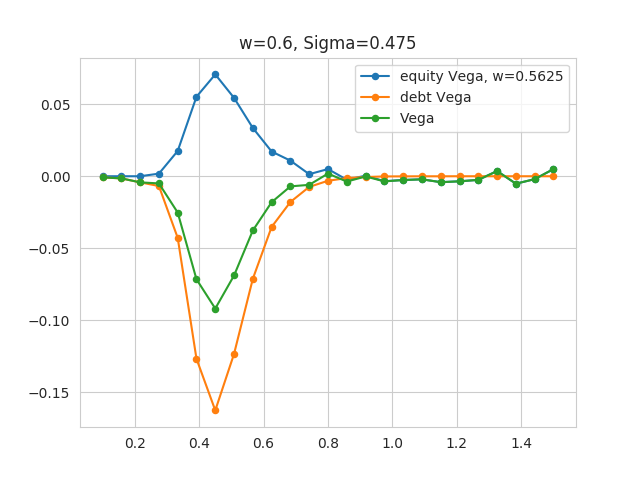

In [63]:
sns.set_style("whitegrid")
cmap = sns.color_palette("muted")#sns.cubehelix_palette(8, light=1)
ccycle = itertools.cycle(cmap)
#sns.set_palette(cmap)

def plot_val(l, ax, val, ds, S0, sigma, greek , title=""):
    nl = np.unique(l.reset_index(level=[1,2,3,4,5]).index.values)
    rl = np.unique(df1.reset_index()['r'])
    N = 2
    for r in rl:
        for w in col_sums[15:16]:
            c = next(ccycle)
            data = l.loc[idx[N, sigma ,w, ds, r, :],['equity ' + greek,'equity ' +greek+ ' var','debt '+greek,\
                                                  'debt '+greek+' var', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['Vega','Vega var', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['Solvent', 'Number Of Samples']]
            #data = l.loc[idx[N,:,val, ds, r],['RS', 'Number Of Samples']]
            n_samples = np.sqrt(np.array([ el for el in data['Number Of Samples'].values]))
            x = l.loc[idx[N, sigma, val, ds, r, :],:].reset_index([0,1,2,3,4]).index.values
            y = np.array([np.sum(el)/(float(N)) for el in data['equity '+greek].values])
            y2 = np.array([np.sum(el)/(float(N)) for el in data['debt '+greek].values])
            y3 = np.array([np.sum(el)/(float(N)) for el in data['debt '+greek].values+data['equity '+greek].values])
            #y_err = np.array([np.sqrt(np.sum(el)/float(N)) for el in data['Delta var'].values])/n_samples
            #y = np.array([np.sum(el[:N]+el[N:])/(float(N)) for el in data['RS'].values])
            #y = np.array([np.sum(el)/(float(N)) for el in data['Solvent'].values])
            #y = np.array([np.sum(el)/(float(N)) for el in data['Vega'].values])
            #y_err = np.array([np.sqrt(np.sum(el)/float(N)) for el in data['Vega var'].values])/n_samples
            ii = np.argsort(x)
            x = x[ii]
            y = y[ii]
            #y_err = y_err[ii]
            #sns.lineplot(x,y, ax = ax)
            ax.plot(x,y, marker='o', markersize=4.4, label="equity "+greek+", w=" + str(w))
            ax.plot(x,y2, marker='o', markersize=4.4, label="debt "+greek)
            ax.plot(x,y3, marker='o', markersize=4.4, label=greek)
            #ax.fill_between(x, y-y_err, y+y_err, color=c, alpha=0.4)
            if title:
                ax.set_title(title)
            else:
                ax.set_title(r'$\sum_j M_{ij} = $' + str(val) +" sigma " +str(sigma))
            ax.legend()
      
#fig, axs = plt.subplots(nrows=len(col_sums), ncols=len(sigma_vals), sharex=True, sharey=False, figsize=(7*len(df_scales), 10*len(col_sums)))
#for ic, val in enumerate(col_sums):
#    for ir, sp in enumerate(sigma_vals):
#        ax = axs[ic,ir]
fix, ax = plt.subplots(nrows = 1, ncols = 1)
val = 0.6
sp = sigma_vals[3]
greek = "Vega"
plot_val(df1 ,ax, val, 1.0, -1, sp, greek ,"w=" + str(val) + ", Sigma=" + str(sp))

#axs[0,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[1,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[2,0].set_ylabel(r'$\Sigma_{ij} \Delta_{ij}$')
#axs[2,0].set_xlabel(r'$\langle k \rangle = n \cdot p$')
#axs[2,1].set_xlabel(r'$\langle k \rangle = n \cdot p$')
#plt.errorbar(x, y, yerr=y_err, fmt='o')

plt.show()

In [189]:
np.unique(df1.reset_index([0,1,2,3,4,5])['col sum'])   #r, S0, default scale, col sum

array([0.1, 0.3, 0.5, 0.7])

In [ ]:
#res = [r.get() for r in async_res]
results = []
res = res_0_4
tmp = combine_results(*res)
results.append(tmp[0])
while len(tmp[1]):
    tmp = combine_results(*tmp[1])
    results.append(tmp[0])
results[1]